<div style="text-align: center; font-size: 20px;"><b>Stats216v: Statistical Learning</b></div>

<br>
<div style="text-align: center">Stanford University</div>
<div style="text-align: center">Summer 2017</div>
<div style="text-align: center">Gyu-Ho Lee (<a href="mailto:gyuhox@gmail.com">gyuhox@gmail.com</a>)</div>

#### 8. Tree-Based Methods

In [2]:
LoadLibraries = function() {
    library(MASS)
    install.packages("ISLR")
    library(ISLR)
    install.packages("tree")
    library(tree)
    library(randomForest)
    install.packages("gbm")
    library(gbm)
    print("Libraries have been loaded!")
}

LoadLibraries()

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


[1] "Libraries have been loaded!"


##### Fitting Classification Trees

In [3]:
names(Carseats)
High = ifelse(Carseats$Sales<=8, "No", "Yes")
head(High)

[1] "Sales"       "CompPrice"   "Income"      "Advertising" "Population" 
 [6] "Price"       "ShelveLoc"   "Age"         "Education"   "Urban"      
[11] "US"

[1] "Yes" "Yes" "Yes" "No"  "No"  "Yes"

In [4]:
Carseats = data.frame(Carseats, High)
head(Carseats)

Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
11.22,111,48,16,260,83,Good,65,10,Yes,Yes,Yes
10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,Yes
7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,No
4.15,141,64,3,340,128,Bad,38,13,Yes,No,No
10.81,124,113,13,501,72,Bad,78,16,No,Yes,Yes


In [5]:
# fit a classification tree
tree.carseats = tree(High~.-Sales, Carseats)
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

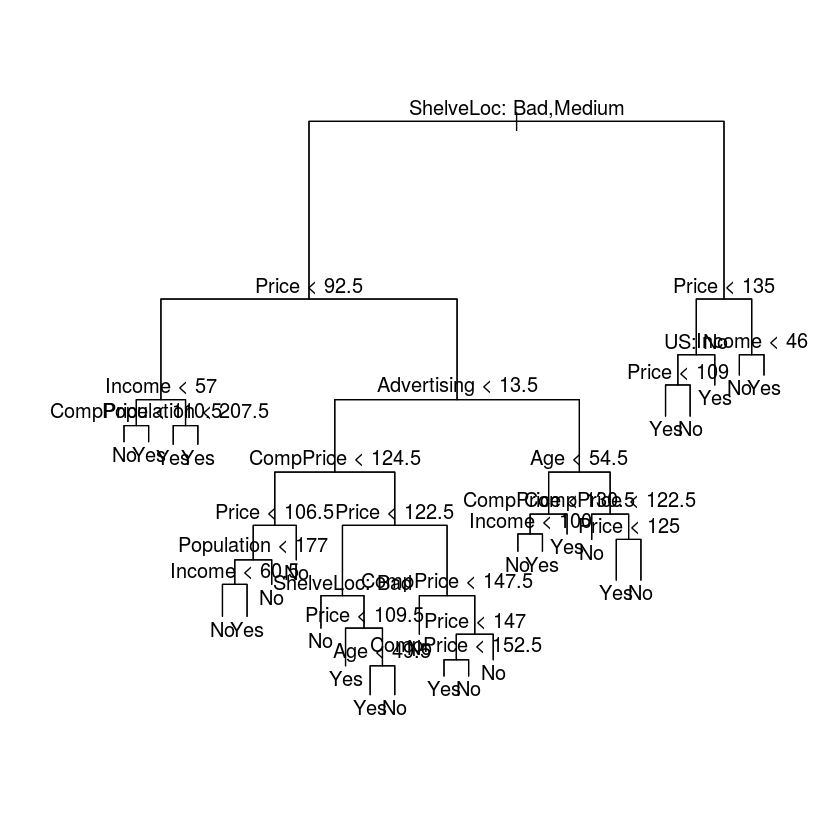

In [6]:
plot(tree.carseats)
text(tree.carseats, pretty=0)

In [7]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

In [8]:
# estimate test error
set.seed(2)
train = sample(1:nrow(Carseats), 200)
Carseats.test = Carseats[-train,]
High.test = High[-train]
tree.carseats = tree(High~.-Sales, Carseats, subset=train)
tree.pred = predict(tree.carseats, Carseats.test, type="class")
table(tree.pred, High.test)

         High.test
tree.pred No Yes
      No  86  27
      Yes 30  57

In [9]:
(86+57)/200

[1] 0.715

In [10]:
# pruning the tree
set.seed(3)
cv.carseats = cv.tree(tree.carseats, FUN=prune.misclass)
cv.carseats

# dev is cross-validation errors

$size
[1] 19 17 14 13  9  7  3  2  1

$dev
[1] 55 55 53 52 50 56 69 65 80

$k
[1]       -Inf  0.0000000  0.6666667  1.0000000  1.7500000  2.0000000  4.2500000
[8]  5.0000000 23.0000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

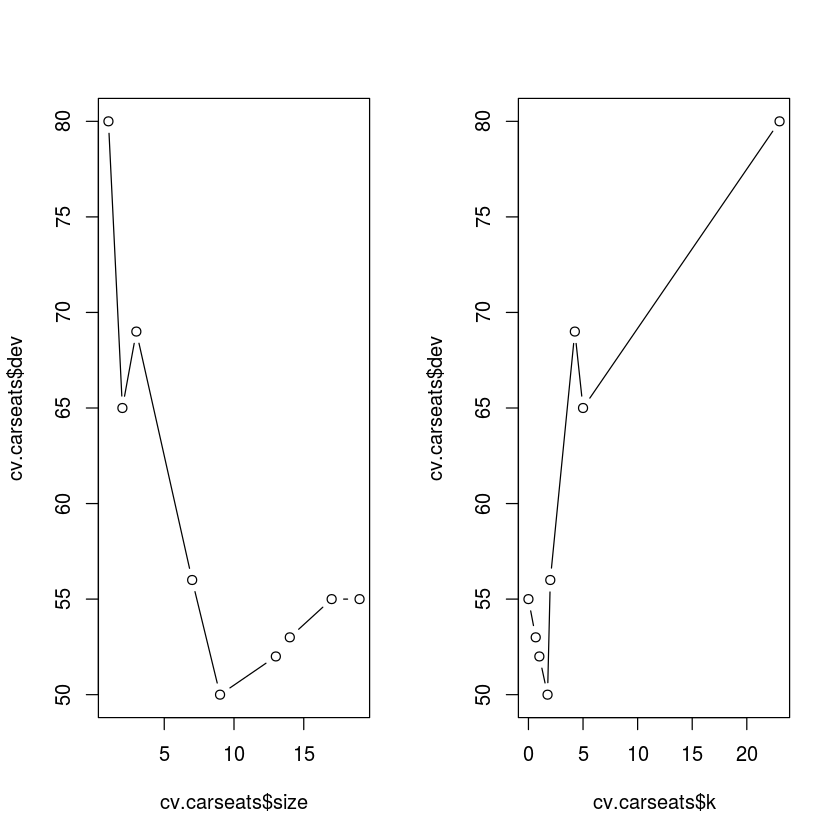

In [11]:
par(mfrow=c(1,2))
plot(cv.carseats$size, cv.carseats$dev, type="b")
plot(cv.carseats$k, cv.carseats$dev, type="b")

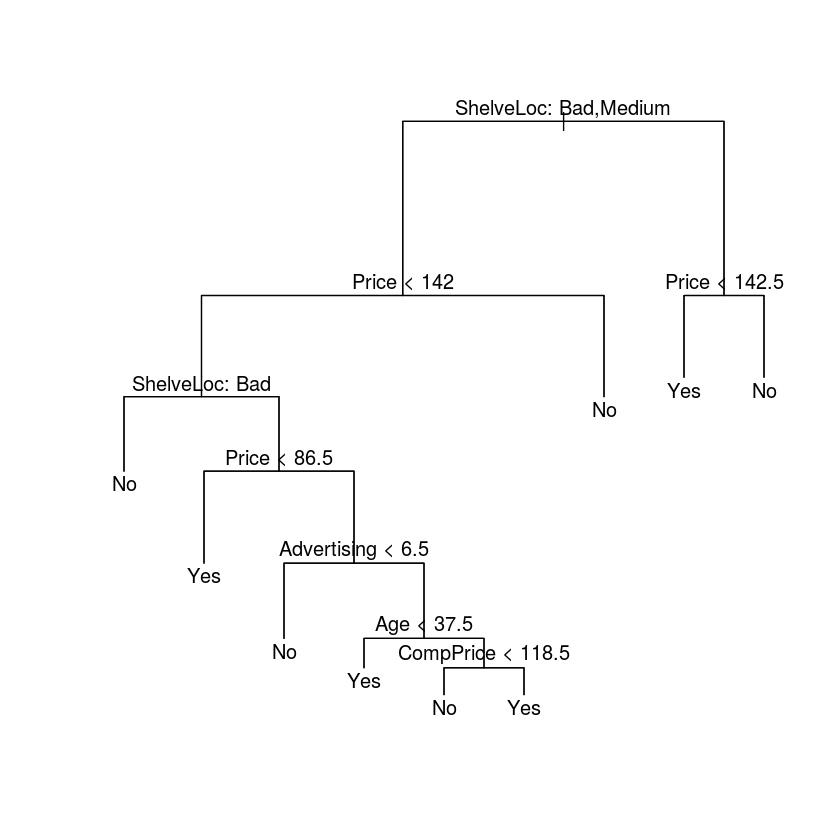

In [12]:
# prune the tree to obtain the nine-node tree
prune.carseats = prune.misclass(tree.carseats, best=9)
plot(prune.carseats)
text(prune.carseats, pretty=0)

In [13]:
# test with test set
tree.pred = predict(prune.carseats, Carseats.test, type="class")
table(tree.pred, High.test)
(94+60)/200

         High.test
tree.pred No Yes
      No  94  24
      Yes 22  60

[1] 0.77

         High.test
tree.pred No Yes
      No  86  22
      Yes 30  62

[1] 0.74

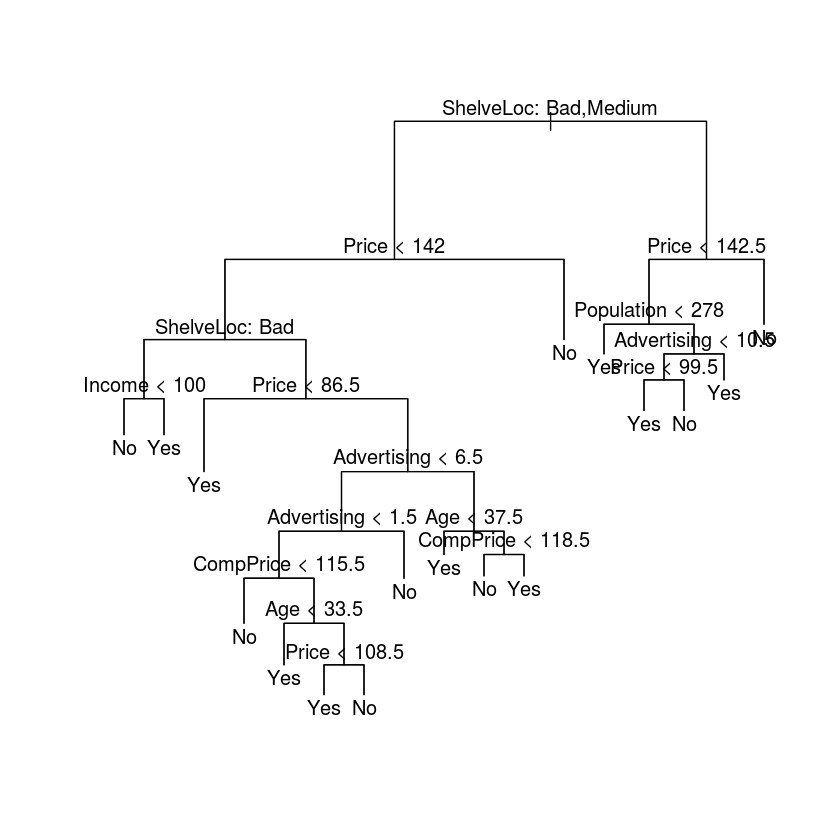

In [14]:
prune.carseats = prune.misclass(tree.carseats, best=15)
plot(prune.carseats)
text(prune.carseats, pretty=0)
tree.pred = predict(prune.carseats, Carseats.test, type="class")
table(tree.pred, High.test)
(86+62)/200

##### Fitting Regression Trees

In [15]:
set.seed(1)
train = sample(1:nrow(Boston), nrow(Boston)/2)
tree.boston = tree(medv~., Boston, subset=train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "lstat" "rm"    "dis"  
Number of terminal nodes:  8 
Residual mean deviance:  12.65 = 3099 / 245 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-14.10000  -2.04200  -0.05357   0.00000   1.96000  12.60000 

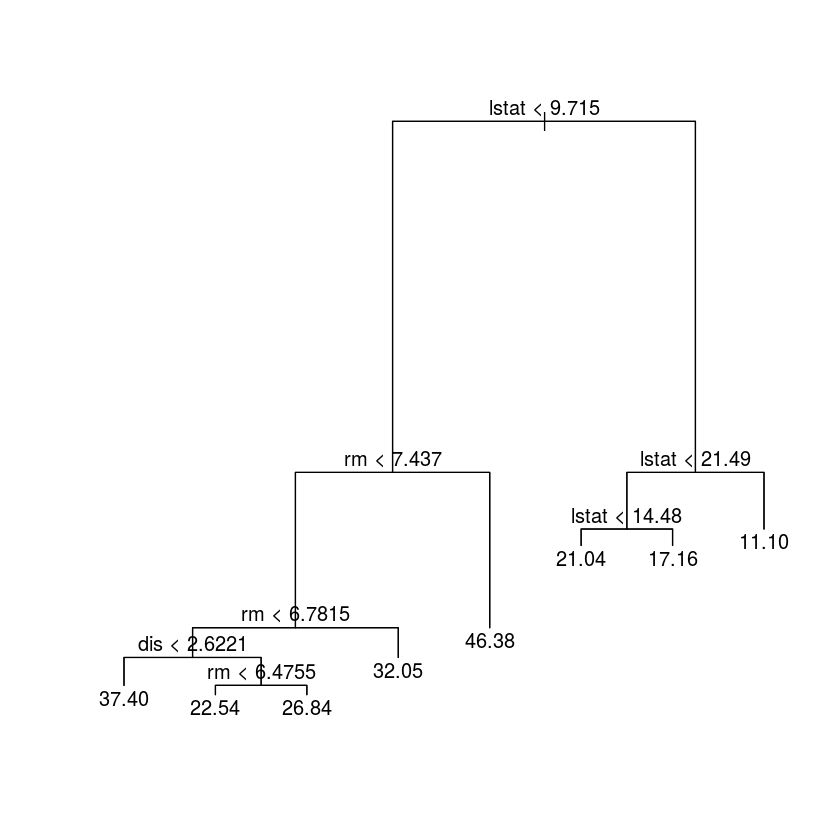

In [16]:
plot(tree.boston)
text(tree.boston, pretty=0)

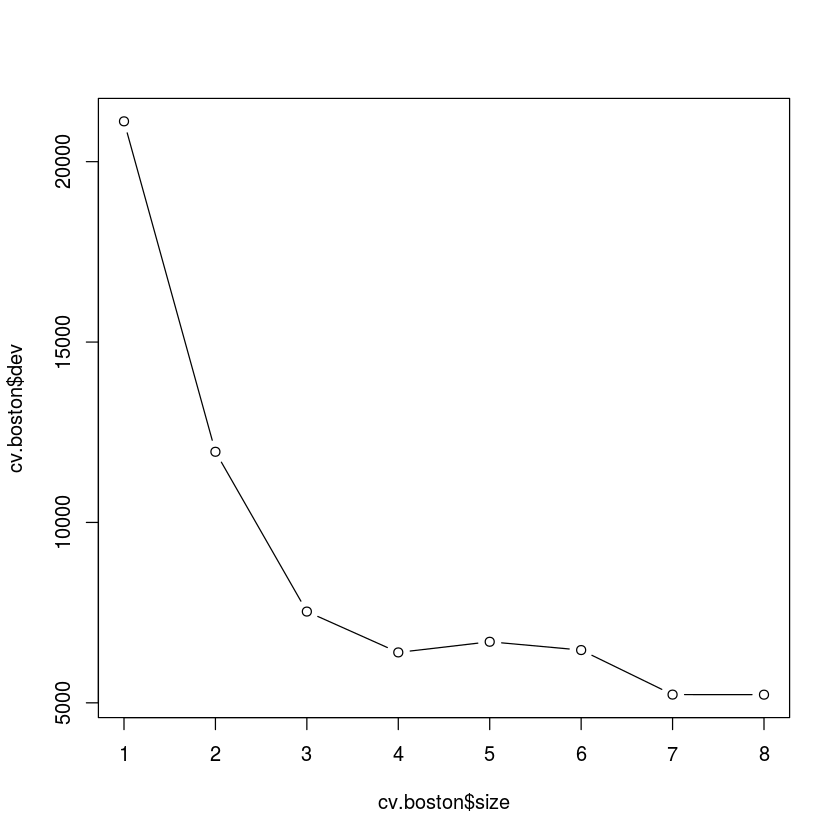

In [17]:
# see if pruning the tree would improve performance
cv.boston = cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type="b")

In [18]:
# most complex tree will be selected by cross-validation

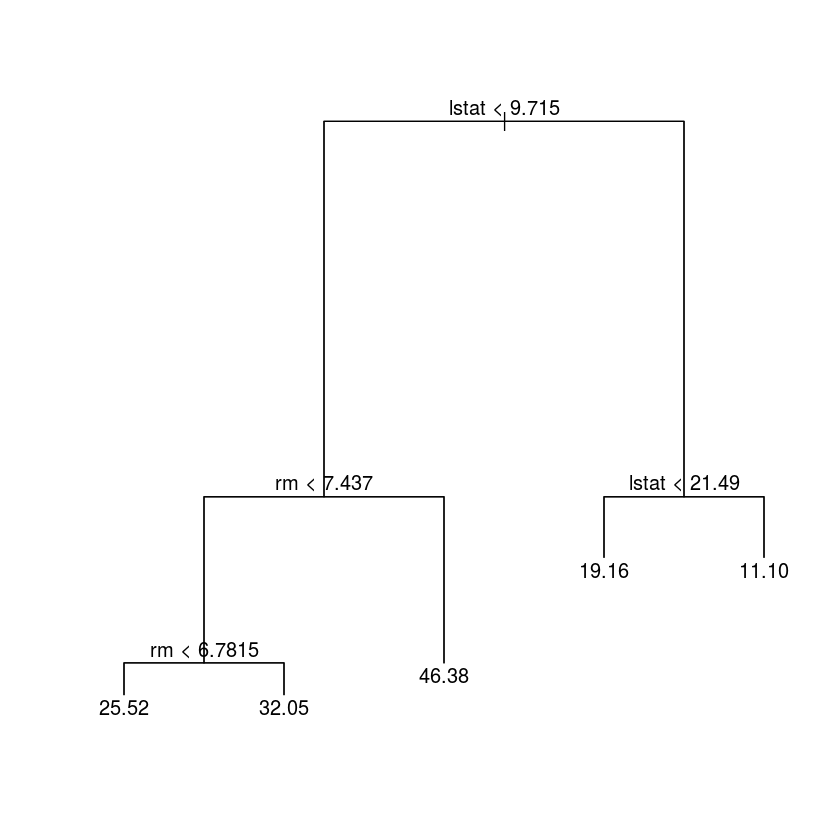

In [19]:
# if we still want to prune
prune.boston = prune.tree(tree.boston, best=5)
plot(prune.boston)
text(prune.boston, pretty=0)

[1] 25.04559

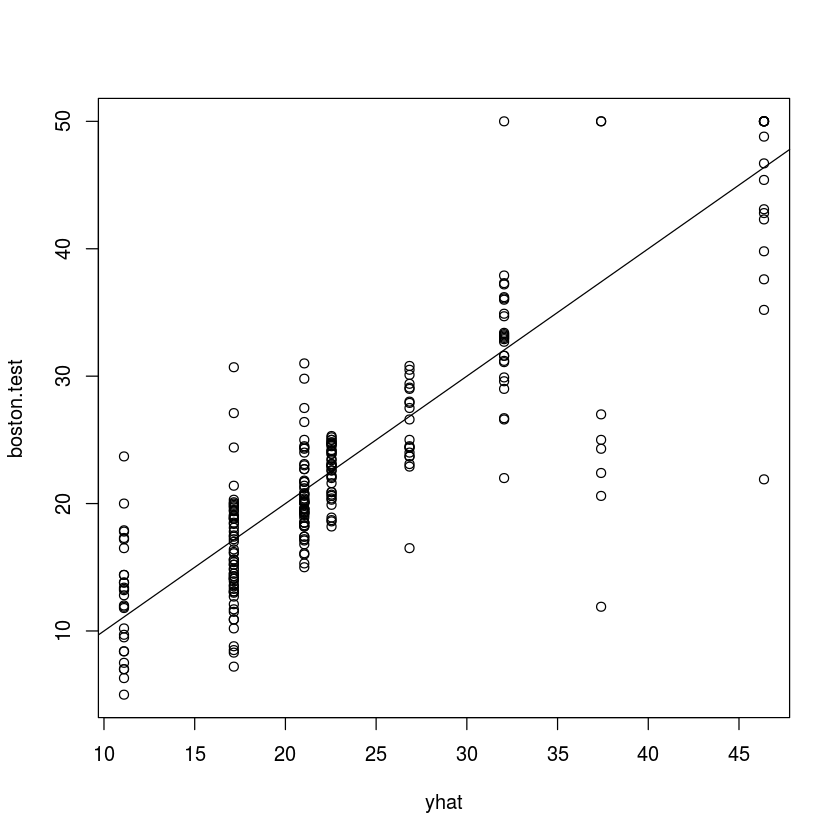

In [20]:
# use un-pruned tree to make predictions
yhat = predict(tree.boston, newdata=Boston[-train,])
boston.test = Boston[-train, "medv"]
plot(yhat, boston.test)
abline(0,1)
mean((yhat-boston.test)^2)

##### Bagging and Random Forests

In [21]:
set.seed(1)

# 13 predictors are considered
bag.boston = randomForest(medv~., data=Boston, subset=train, mtry=12, importance=TRUE)
bag.boston


Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 12, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 12

          Mean of squared residuals: 11.1256
                    % Var explained: 86.53

[1] 13.03768

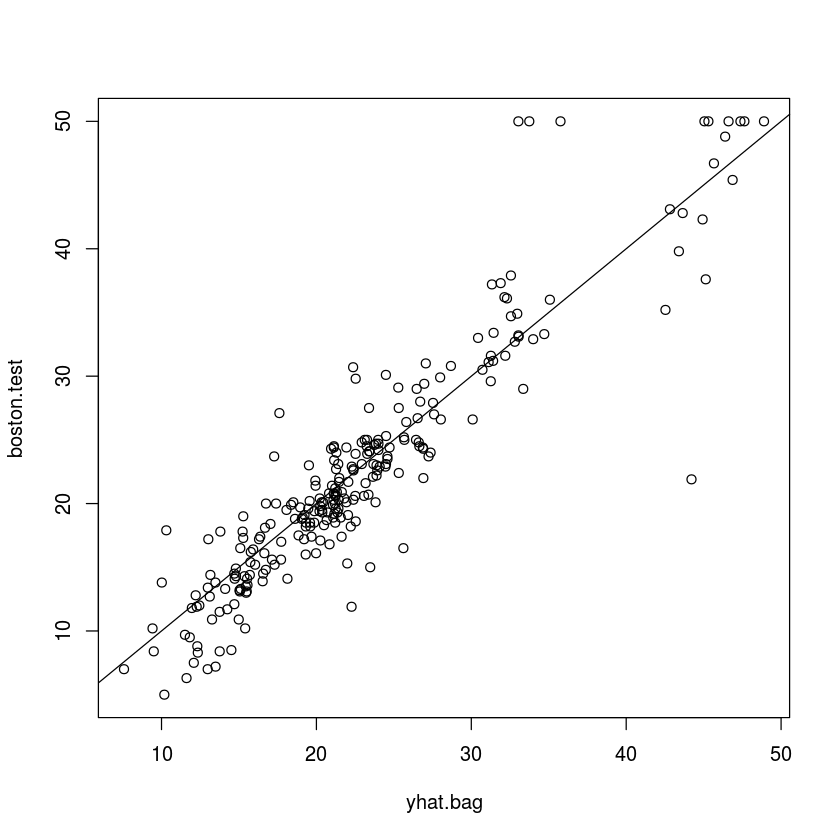

In [22]:
# predict with bagged model
yhat.bag = predict(bag.boston, newdata=Boston[-train,])
plot(yhat.bag, boston.test)
abline(0,1)
mean((yhat.bag-boston.test)^2)

In [23]:
# predict with random forest
bag.boston = randomForest(medv~., data=Boston, subset=train, mtry=13, ntree=25)
yhat.bag = predict(bag.boston, newdata=Boston[-train,])
mean((yhat.bag-boston.test)^2)

[1] 14.76543

In [24]:
set.seed(1)
rf.boston = randomForest(medv~., data=Boston, subset=train, mtry=6, importance=TRUE)
yhat.rf = predict(rf.boston, newdata=Boston[-train,])
mean((yhat.rf - boston.test)^2)

[1] 11.48022

In [25]:
importance(rf.boston)

,%IncMSE,IncNodePurity
crim,12.547772,1094.65382
zn,1.375489,64.40060
indus,9.304258,1086.09103
chas,2.518766,76.36804
nox,12.835614,1008.73703
rm,31.646147,6705.02638
age,9.970243,575.13702
dis,12.774430,1351.01978
rad,3.911852,93.78200
tax,7.624043,453.19472


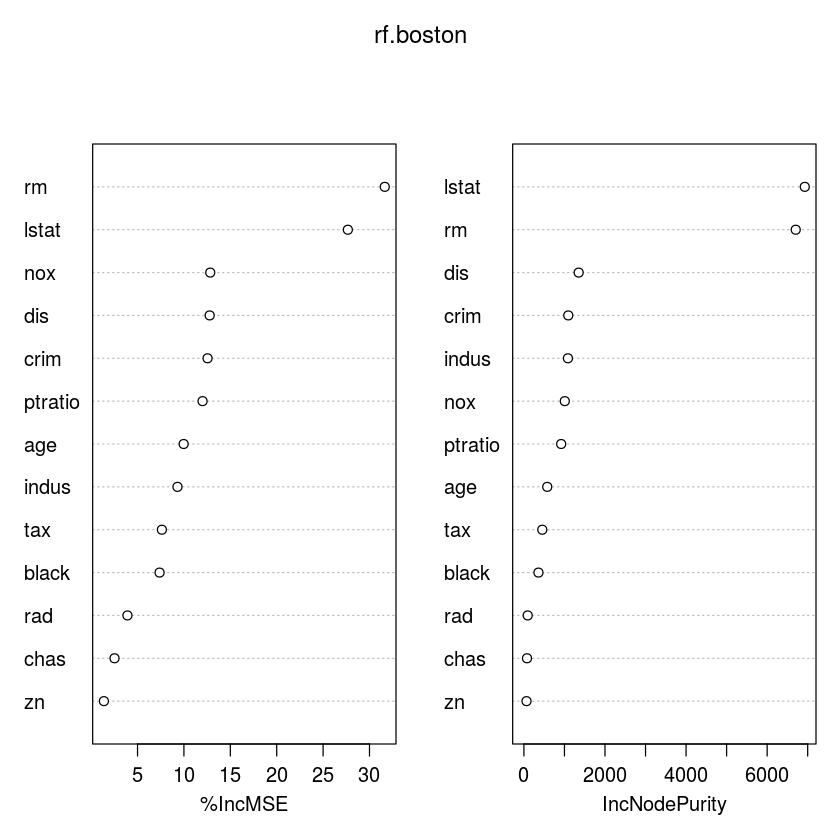

In [26]:
varImpPlot(rf.boston)

##### Boosting

,var,rel.inf
lstat,lstat,45.9627334
rm,rm,31.2238187
dis,dis,6.8087398
crim,crim,4.0743784
nox,nox,2.5605001
ptratio,ptratio,2.2748652
black,black,1.7971159
age,age,1.6488532
tax,tax,1.3595005
indus,indus,1.2705924


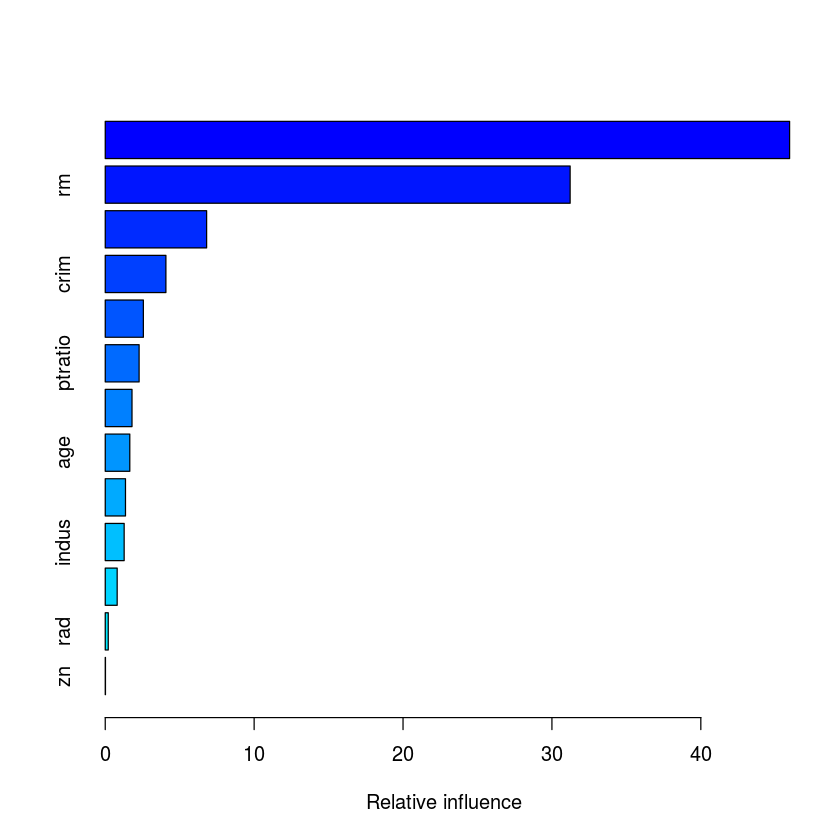

In [27]:
set.seed(1)
boost.boston = gbm(medv~., data=Boston[train,], distribution="gaussian", n.trees=5000, interaction.depth=4)
summary(boost.boston)

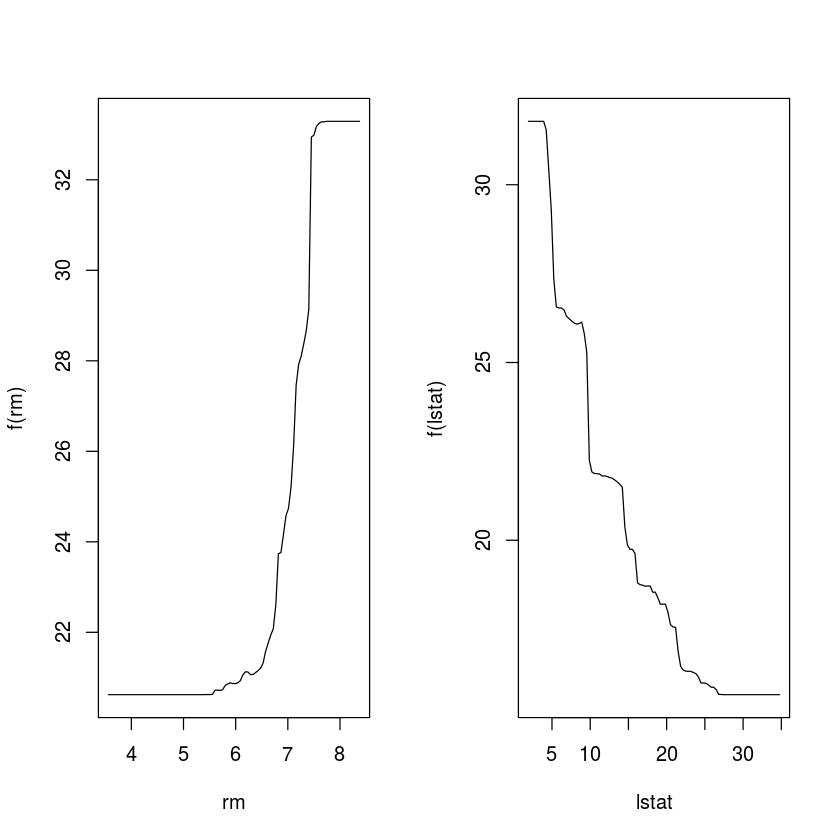

In [28]:
par(mfrow=c(1,2))
plot(boost.boston, i="rm")
plot(boost.boston, i="lstat")

In [29]:
yhat.boost = predict(boost.boston, newdata=Boston[-train,], n.trees=5000)
mean((yhat.boost - boston.test)^2)

[1] 11.84434

In [30]:
# λ = 0.2
boost.boston = gbm(medv~., data=Boston[train,], distribution="gaussian", n.trees=5000, interaction.depth=4,
                  shrinkage=0.2, verbose=F)
yhat.boost = predict(boost.boston, newdata=Boston[-train,], n.trees=5000)
mean((yhat.boost - boston.test)^2)

[1] 11.51109